In [1]:
import torchvision , torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from rcnn_transfrom import InterpolationTransform as it

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = 'cuda:0'
num_classes = 2

def get_instance_segmentation_model(num_classes,pretrained=True,mode='bilinear'):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)
    model.transform = it(min_size=(800,), max_size=1333,image_mean=[0.485, 0.456, 0.406],image_std=[0.229, 0.224, 0.225],mode=mode)
    return model

In [3]:
mode_names = ['edsr','espcn','fsrcnn','lapsrn']

mode_name  = 'ensemble-'+ mode_names[0] # edsr: slow, espcn,fsrcnn: fast, 'lapsrn': medium
edsr_m = get_instance_segmentation_model(num_classes,pretrained=False,mode=mode_name)
edsr_m.to(device)
m_path = f'./model/pf_4_{mode_name}.pth'
edsr_pter = torch.load(m_path)
# bicubic_m.eval()
# bicubic_m.load_state_dict(bicubic_pter['model_state_dict'])

mode_name  = 'ensemble-'+ mode_names[1]
espcn_m = get_instance_segmentation_model(num_classes,pretrained=False,mode=mode_name)
espcn_m.to(device)
m_path = f'./model/pf_4_{mode_name}.pth'
espcn_pter = torch.load(m_path)
# nearest_m.eval()
# nearest_m.load_state_dict(nearest_pter['model_state_dict'])

device = 'cuda:1'
mode_name  = 'ensemble-'+ mode_names[2]
fsrcnn_m = get_instance_segmentation_model(num_classes,pretrained=False,mode=mode_name)
fsrcnn_m.to(device)
m_path = f'./model/pf_4_{mode_name}.pth'
fsrcnn_pter = torch.load(m_path)
# bilinear_m.eval()
# bilinear_m.load_state_dict(bilinear_pter['model_state_dict'])

mode_name  = 'ensemble-'+ mode_names[3]
lapsrn_m = get_instance_segmentation_model(num_classes,pretrained=False,mode=mode_name)
lapsrn_m.to(device)
m_path = f'./model/pf_4_{mode_name}.pth'
lapsrn_pter = torch.load(m_path)

edsr_evals   = edsr_pter['evaluators']
espcn_evals  = espcn_pter['evaluators']
fsrcnn_evals = fsrcnn_pter['evaluators']
lapsrn_evals = lapsrn_pter['evaluators']

In [6]:
mode_name  = 'bilinear'
bilinear_m = get_instance_segmentation_model(num_classes,pretrained=False,mode=mode_name)
bilinear_m.to(device)
m_path = f'./model/pf_4_{mode_name}.pth'
bilinear_pter = torch.load(m_path)
bilinear_evals = bilinear_pter['evaluators']

In [17]:
if 'bilinear' not in mode_names:
    mode_names.append('bilinear')

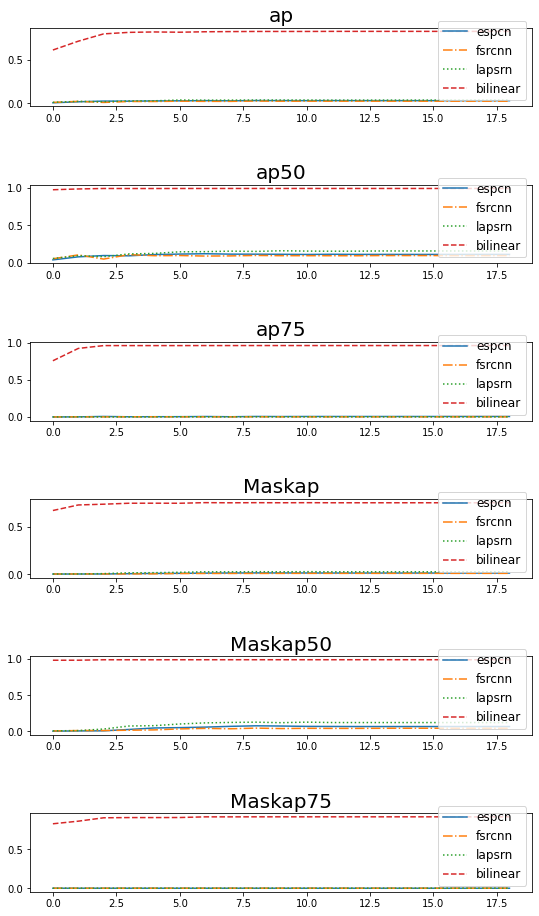

In [23]:
from matplotlib import pyplot as plt
interpols = mode_names# ['bicubic','nearest','bilinear']
interpols = ['espcn','fsrcnn','lapsrn','bilinear']
metric_name   = ['ap','ap50','ap75','Maskap','Maskap50','Maskap75']
num_metric    = len(metric_name)
limit         = 19

# graph style
line_styles   = ['-','-.',':','--']
legend_sizes  = ['xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large']

f, axs = plt.subplots(num_metric, 1, figsize=(9, 15),sharex=False) # w,h

for j,inter in enumerate(interpols): # ['bicubic','nearest','bilinear']
    exec(f'evaluators={inter}_evals')
    # metrics = {'ap':[], 'ap50':[], 'ap75':[], ..., 'Maskap75':[]}
    metrics = dict(zip( metric_name, list( [] for _ in range(len(metric_name))  )  
                      ))
    # to fill metrics
    for evtor in evaluators:
        for iou_type, coco_eval in evtor.coco_eval.items():
            #coco_eval.summarize()
            #  iou_type : 'bbox' ,'segm'
            if iou_type == 'bbox':
                aps = coco_eval.stats[:3]
                metrics['ap'].append(aps[0])
                metrics['ap50'].append(aps[1])
                metrics['ap75'].append(aps[2])

            else : # 'segm'
                aps = coco_eval.stats[:3]
                metrics['Maskap'].append(aps[0])
                metrics['Maskap50'].append(aps[1])
                metrics['Maskap75'].append(aps[2])
    
    metrics_keys = list(metrics.keys() )
    for i,met_name in enumerate(metrics):
        axs[i].set_title(met_name,fontdict={'fontsize':20})
        axs[i].plot( metrics[met_name][:limit],linestyle=line_styles[j],label=inter)
        axs[i].legend(loc='lower right',fontsize=legend_sizes[4] )
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=1)
# plt.subplots(constrained_layout=True)
    #         coco_eval.stats[:3] # ap ,ap0.5 , ap0.75

# plt.savefig('assets/pf3.jpg')

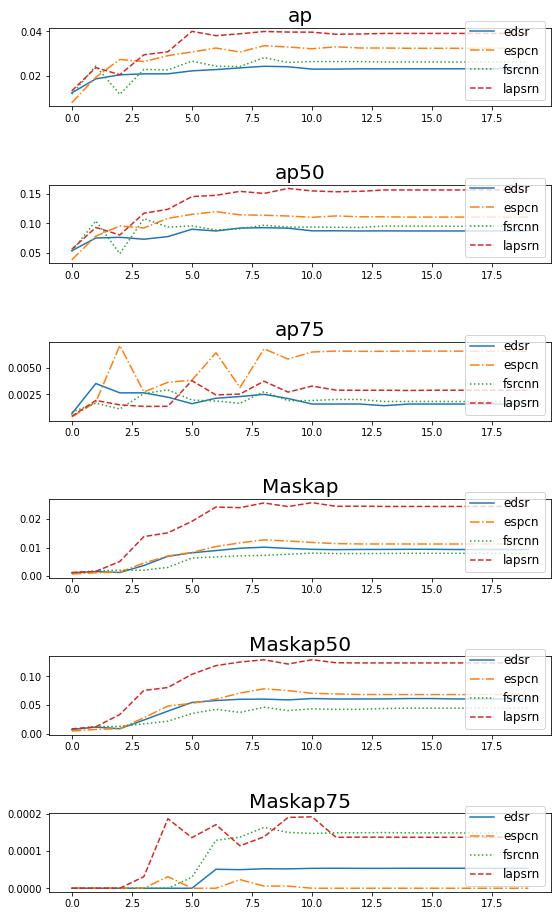

In [4]:
from matplotlib import pyplot as plt
interpols = mode_names # ['bicubic','nearest','bilinear']
metric_name   = ['ap','ap50','ap75','Maskap','Maskap50','Maskap75']
num_metric    = len(metric_name)
limit         = 20
line_styles   = ['-','-.',':','--']
legend_sizes  = ['xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large']

f, axs = plt.subplots(num_metric, 1, figsize=(9, 15),sharex=False) # w,h

for j,inter in enumerate(interpols): # ['bicubic','nearest','bilinear']
    exec(f'evaluators={inter}_evals')
    # metrics = {'ap':[], 'ap50':[], 'ap75':[], ..., 'Maskap75':[]}
    metrics = dict(zip( metric_name, list( [] for _ in range(len(metric_name))  )  
                      ))
    # to fill metrics
    for evtor in evaluators:
        for iou_type, coco_eval in evtor.coco_eval.items():
            #coco_eval.summarize()
            #  iou_type : 'bbox' ,'segm'
            if iou_type == 'bbox':
                aps = coco_eval.stats[:3]
                metrics['ap'].append(aps[0])
                metrics['ap50'].append(aps[1])
                metrics['ap75'].append(aps[2])

            else : # 'segm'
                aps = coco_eval.stats[:3]
                metrics['Maskap'].append(aps[0])
                metrics['Maskap50'].append(aps[1])
                metrics['Maskap75'].append(aps[2])
    
    metrics_keys = list(metrics.keys() )
    for i,met_name in enumerate(metrics):
        axs[i].set_title(met_name,fontdict={'fontsize':20})
        axs[i].plot( metrics[met_name][:limit],linestyle=line_styles[j],label=inter)
        axs[i].legend(loc='lower right',fontsize=legend_sizes[4] )
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=1)
# plt.subplots(constrained_layout=True)
    #         coco_eval.stats[:3] # ap ,ap0.5 , ap0.75

# plt.savefig('assets/pf3.jpg')

In [27]:
interpols

['espcn', 'fsrcnn', 'lapsrn', 'bilinear']

In [28]:
import pandas as pd
num_epoch = 11
aps = []
interpols = ['edsr','espcn', 'fsrcnn', 'lapsrn', 'bilinear']
for inter in interpols:
    exec(f"bbox = {inter}_evals[num_epoch].coco_eval['bbox'].stats[:3]")
    exec(f"segm = {inter}_evals[num_epoch].coco_eval['segm'].stats[:3]")
    row = bbox.tolist()+segm.tolist()
    aps.append(row)
pd.DataFrame(aps,index=interpols,columns=metric_name)

,ap,ap50,ap75,Maskap,Maskap50,Maskap75
edsr,0.023089,0.087446,0.001568,0.009246,0.060508,0.000054
espcn,0.033005,0.112603,0.006576,0.011370,0.069311,0.000000
fsrcnn,0.026428,0.093249,0.001997,0.007861,0.042564,0.000149
lapsrn,0.038608,0.153523,0.002881,0.024488,0.123362,0.000137
bilinear,0.830602,0.989097,0.961461,0.749893,0.989097,0.915575


In [5]:
import pandas as pd
num_epoch = 11
aps = []
for inter in interpols:
    exec(f"bbox = {inter}_evals[num_epoch].coco_eval['bbox'].stats[:3]")
    exec(f"segm = {inter}_evals[num_epoch].coco_eval['segm'].stats[:3]")
    row = bbox.tolist()+segm.tolist()
    aps.append(row)
pd.DataFrame(aps,index=interpols,columns=metric_name)

,ap,ap50,ap75,Maskap,Maskap50,Maskap75
edsr,0.023089,0.087446,0.001568,0.009246,0.060508,0.000054
espcn,0.033005,0.112603,0.006576,0.011370,0.069311,0.000000
fsrcnn,0.026428,0.093249,0.001997,0.007861,0.042564,0.000149
lapsrn,0.038608,0.153523,0.002881,0.024488,0.123362,0.000137


In [ ]:
	 ap       	ap50	ap75	Maskap	Maskap50	Maskap75
bicubic	0.214964	0.591654	0.085874	0.266878	0.690976	0.129635
nearest	0.132463	0.433494	0.036978	0.163742	0.464086	0.047593
bilinear 0.181566	0.554535	0.063565	0.215242	0.650762	0.061373

### Pretrained: False 

In [3]:
mode_names = ['edsr','espcn','fsrcnn','lapsrn','bilinear','bicubic']
pretrained = False
mode_name  = 'ensemble-'+ mode_names[0] # edsr: slow, espcn,fsrcnn: fast, 'lapsrn': medium
edsr_m = get_instance_segmentation_model(num_classes,pretrained=False,mode=mode_name)
edsr_m.to(device)
if pretrained:
    m_path = f'./model/pf_4_{mode_name}.pth'
else:
    m_path = f'./model/pf_4_{mode_name}_{pretrained}.pth'
edsr_pter = torch.load(m_path)
# bicubic_m.eval()
# bicubic_m.load_state_dict(bicubic_pter['model_state_dict'])

mode_name  = 'ensemble-'+ mode_names[1]
espcn_m = get_instance_segmentation_model(num_classes,pretrained=False,mode=mode_name)
espcn_m.to(device)
if pretrained:
    m_path = f'./model/pf_4_{mode_name}.pth'
else:
    m_path = f'./model/pf_4_{mode_name}_{pretrained}.pth'
espcn_pter = torch.load(m_path)
# nearest_m.eval()
# nearest_m.load_state_dict(nearest_pter['model_state_dict'])

device = 'cuda:1'
mode_name  = 'ensemble-'+ mode_names[2]
fsrcnn_m = get_instance_segmentation_model(num_classes,pretrained=False,mode=mode_name)
fsrcnn_m.to(device)
if pretrained:
    m_path = f'./model/pf_4_{mode_name}.pth'
else:
    m_path = f'./model/pf_4_{mode_name}_{pretrained}.pth'
fsrcnn_pter = torch.load(m_path)
# bilinear_m.eval()
# bilinear_m.load_state_dict(bilinear_pter['model_state_dict'])

mode_name  = 'ensemble-'+ mode_names[3]
lapsrn_m = get_instance_segmentation_model(num_classes,pretrained=False,mode=mode_name)
lapsrn_m.to(device)
if pretrained:
    m_path = f'./model/pf_4_{mode_name}.pth'
else:
    m_path = f'./model/pf_4_{mode_name}_{pretrained}.pth'
lapsrn_pter = torch.load(m_path)

mode_name  = mode_names[4]
bilinear_m = get_instance_segmentation_model(num_classes,pretrained=False,mode=mode_name)
bilinear_m.to(device)
if pretrained:
    m_path = f'./model/pf_4_{mode_name}.pth'
else:
    m_path = f'./model/pf_4_{mode_name}_{pretrained}.pth'
bilinear_pter = torch.load(m_path)

mode_name  = mode_names[5]
bicubic_m = get_instance_segmentation_model(num_classes,pretrained=False,mode=mode_name)
bicubic_m.to(device)
if pretrained:
    m_path = f'./model/pf_4_{mode_name}.pth'
else:
    m_path = f'./model/pf_4_{mode_name}_{pretrained}.pth'
bicubic_pter = torch.load(m_path)

edsr_evals   = edsr_pter['evaluators']
espcn_evals  = espcn_pter['evaluators']
fsrcnn_evals = fsrcnn_pter['evaluators']
lapsrn_evals = lapsrn_pter['evaluators']
bilinear_evals = bilinear_pter['evaluators']
bicubic_evals = bicubic_pter['evaluators']

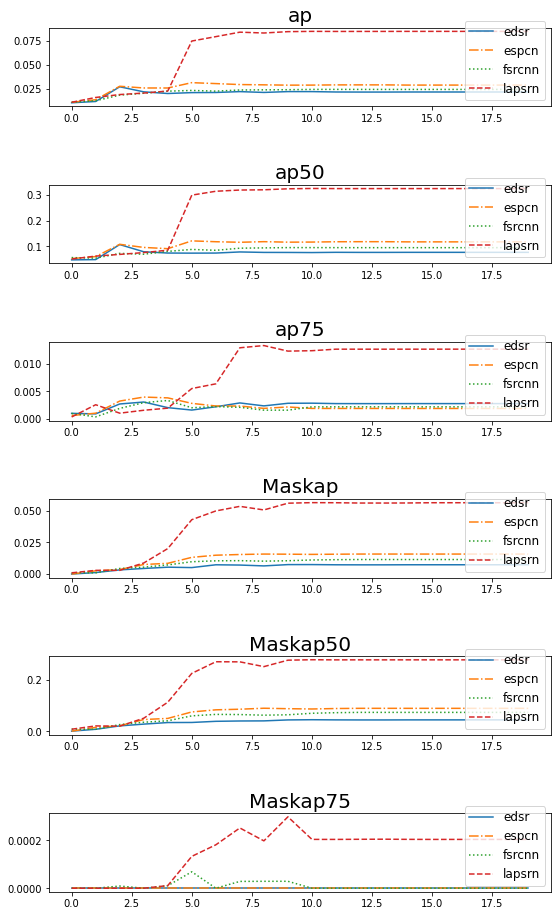

In [4]:
from matplotlib import pyplot as plt
interpols = ['edsr','espcn','fsrcnn','lapsrn'] # ['bicubic','nearest','bilinear']
metric_name   = ['ap','ap50','ap75','Maskap','Maskap50','Maskap75']
num_metric    = len(metric_name)
limit         = 20
line_styles   = ['-','-.',':','--']
legend_sizes  = ['xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large']

f, axs = plt.subplots(num_metric, 1, figsize=(9, 15),sharex=False) # w,h

for j,inter in enumerate(interpols): # ['bicubic','nearest','bilinear']
    exec(f'evaluators={inter}_evals')
    # metrics = {'ap':[], 'ap50':[], 'ap75':[], ..., 'Maskap75':[]}
    metrics = dict(zip( metric_name, list( [] for _ in range(len(metric_name))  )  
                      ))
    # to fill metrics
    for evtor in evaluators:
        for iou_type, coco_eval in evtor.coco_eval.items():
            #coco_eval.summarize()
            #  iou_type : 'bbox' ,'segm'
            if iou_type == 'bbox':
                aps = coco_eval.stats[:3]
                metrics['ap'].append(aps[0])
                metrics['ap50'].append(aps[1])
                metrics['ap75'].append(aps[2])

            else : # 'segm'
                aps = coco_eval.stats[:3]
                metrics['Maskap'].append(aps[0])
                metrics['Maskap50'].append(aps[1])
                metrics['Maskap75'].append(aps[2])
    
    metrics_keys = list(metrics.keys() )
    for i,met_name in enumerate(metrics):
        axs[i].set_title(met_name,fontdict={'fontsize':20})
        axs[i].plot( metrics[met_name][:limit],linestyle=line_styles[j],label=inter)
        axs[i].legend(loc='lower right',fontsize=legend_sizes[4] )
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=1)
# plt.subplots(constrained_layout=True)
    #         coco_eval.stats[:3] # ap ,ap0.5 , ap0.75

# plt.savefig('assets/pf3.jpg')

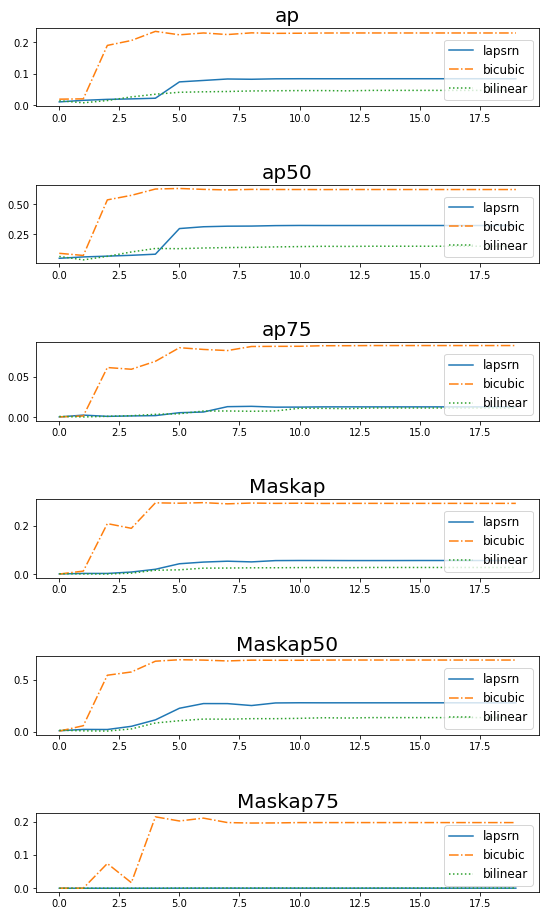

In [5]:
from matplotlib import pyplot as plt
interpols = ['lapsrn','bicubic','bilinear'] #['edsr','espcn','fsrcnn','lapsrn'] # ['bicubic','nearest','bilinear']
metric_name   = ['ap','ap50','ap75','Maskap','Maskap50','Maskap75']
num_metric    = len(metric_name)
limit         = 20
line_styles   = ['-','-.',':','--']
legend_sizes  = ['xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large']

f, axs = plt.subplots(num_metric, 1, figsize=(9, 15),sharex=False) # w,h

for j,inter in enumerate(interpols): # ['bicubic','nearest','bilinear']
    exec(f'evaluators={inter}_evals')
    # metrics = {'ap':[], 'ap50':[], 'ap75':[], ..., 'Maskap75':[]}
    metrics = dict(zip( metric_name, list( [] for _ in range(len(metric_name))  )  
                      ))
    # to fill metrics
    for evtor in evaluators:
        for iou_type, coco_eval in evtor.coco_eval.items():
            #coco_eval.summarize()
            #  iou_type : 'bbox' ,'segm'
            if iou_type == 'bbox':
                aps = coco_eval.stats[:3]
                metrics['ap'].append(aps[0])
                metrics['ap50'].append(aps[1])
                metrics['ap75'].append(aps[2])

            else : # 'segm'
                aps = coco_eval.stats[:3]
                metrics['Maskap'].append(aps[0])
                metrics['Maskap50'].append(aps[1])
                metrics['Maskap75'].append(aps[2])
    
    metrics_keys = list(metrics.keys() )
    for i,met_name in enumerate(metrics):
        axs[i].set_title(met_name,fontdict={'fontsize':20})
        axs[i].plot( metrics[met_name][:limit],linestyle=line_styles[j],label=inter)
        axs[i].legend(loc='lower right',fontsize=legend_sizes[4] )
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=1)
# plt.subplots(constrained_layout=True)
    #         coco_eval.stats[:3] # ap ,ap0.5 , ap0.75

# plt.savefig('assets/pf3.jpg')

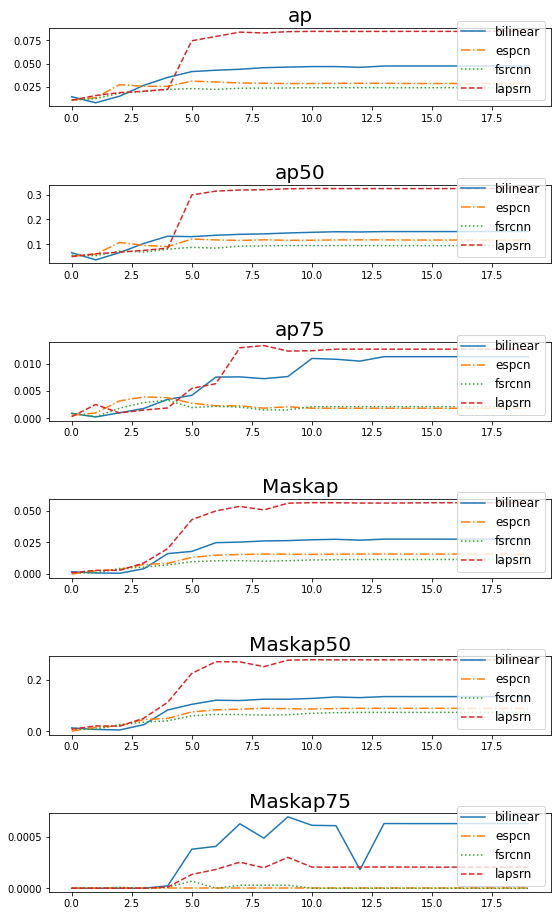

In [6]:
from matplotlib import pyplot as plt
interpols = ['bilinear','espcn','fsrcnn','lapsrn'] # ['bicubic','nearest','bilinear']
metric_name   = ['ap','ap50','ap75','Maskap','Maskap50','Maskap75']
num_metric    = len(metric_name)
limit         = 20
line_styles   = ['-','-.',':','--']
legend_sizes  = ['xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large']

f, axs = plt.subplots(num_metric, 1, figsize=(9, 15),sharex=False) # w,h

for j,inter in enumerate(interpols): # ['bicubic','nearest','bilinear']
    exec(f'evaluators={inter}_evals')
    # metrics = {'ap':[], 'ap50':[], 'ap75':[], ..., 'Maskap75':[]}
    metrics = dict(zip( metric_name, list( [] for _ in range(len(metric_name))  )  
                      ))
    # to fill metrics
    for evtor in evaluators:
        for iou_type, coco_eval in evtor.coco_eval.items():
            #coco_eval.summarize()
            #  iou_type : 'bbox' ,'segm'
            if iou_type == 'bbox':
                aps = coco_eval.stats[:3]
                metrics['ap'].append(aps[0])
                metrics['ap50'].append(aps[1])
                metrics['ap75'].append(aps[2])

            else : # 'segm'
                aps = coco_eval.stats[:3]
                metrics['Maskap'].append(aps[0])
                metrics['Maskap50'].append(aps[1])
                metrics['Maskap75'].append(aps[2])
    
    metrics_keys = list(metrics.keys() )
    for i,met_name in enumerate(metrics):
        axs[i].set_title(met_name,fontdict={'fontsize':20})
        axs[i].plot( metrics[met_name][:limit],linestyle=line_styles[j],label=inter)
        axs[i].legend(loc='lower right',fontsize=legend_sizes[4] )
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=1)
# plt.subplots(constrained_layout=True)
    #         coco_eval.stats[:3] # ap ,ap0.5 , ap0.75

# plt.savefig('assets/pf3.jpg')

In [9]:
import pandas as pd
interpols = mode_names
num_epoch = 15
aps = []
for inter in interpols:
    exec(f"bbox = {inter}_evals[num_epoch].coco_eval['bbox'].stats[:3]")
    exec(f"segm = {inter}_evals[num_epoch].coco_eval['segm'].stats[:3]")
    row = bbox.tolist()+segm.tolist()
    aps.append(row)
pd.DataFrame(aps,index=interpols,columns=metric_name)

,ap,ap50,ap75,Maskap,Maskap50,Maskap75
edsr,0.021575,0.076968,0.002739,0.007346,0.043716,0.000000
espcn,0.028759,0.117519,0.001853,0.015806,0.088492,0.000000
fsrcnn,0.024257,0.095030,0.002151,0.011480,0.072818,0.000000
lapsrn,0.084554,0.323772,0.012674,0.056397,0.276727,0.000204
bilinear,0.047496,0.151449,0.011297,0.027602,0.134032,0.000625
bicubic,0.230051,0.623110,0.088138,0.292642,0.688875,0.196919


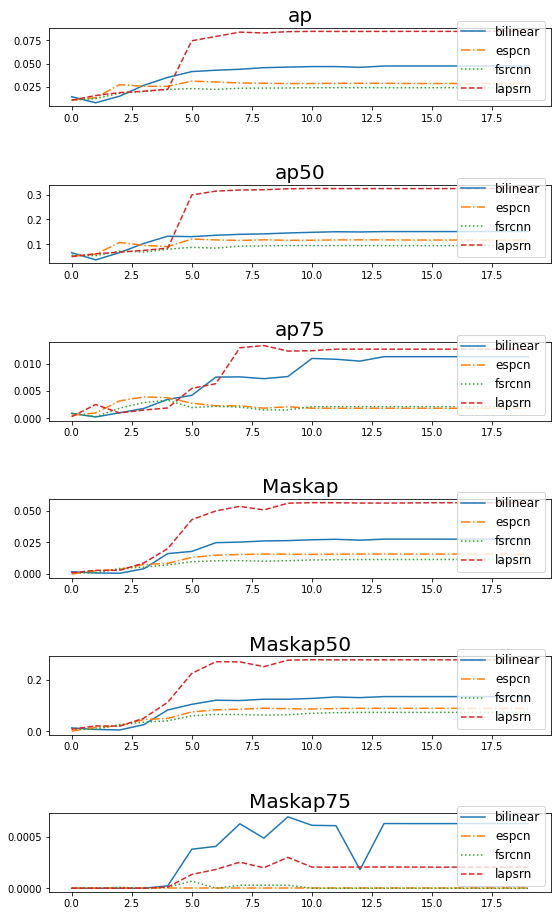

In [4]:
from matplotlib import pyplot as plt
interpols = ['bilinear','espcn','fsrcnn','lapsrn'] # ['bicubic','nearest','bilinear']
metric_name   = ['ap','ap50','ap75','Maskap','Maskap50','Maskap75']
num_metric    = len(metric_name)
limit         = 20
line_styles   = ['-','-.',':','--']
legend_sizes  = ['xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large']

f, axs = plt.subplots(num_metric, 1, figsize=(9, 15),sharex=False) # w,h

for j,inter in enumerate(interpols): # ['bicubic','nearest','bilinear']
    exec(f'evaluators={inter}_evals')
    # metrics = {'ap':[], 'ap50':[], 'ap75':[], ..., 'Maskap75':[]}
    metrics = dict(zip( metric_name, list( [] for _ in range(len(metric_name))  )  
                      ))
    # to fill metrics
    for evtor in evaluators:
        for iou_type, coco_eval in evtor.coco_eval.items():
            #coco_eval.summarize()
            #  iou_type : 'bbox' ,'segm'
            if iou_type == 'bbox':
                aps = coco_eval.stats[:3]
                metrics['ap'].append(aps[0])
                metrics['ap50'].append(aps[1])
                metrics['ap75'].append(aps[2])

            else : # 'segm'
                aps = coco_eval.stats[:3]
                metrics['Maskap'].append(aps[0])
                metrics['Maskap50'].append(aps[1])
                metrics['Maskap75'].append(aps[2])
    
    metrics_keys = list(metrics.keys() )
    for i,met_name in enumerate(metrics):
        axs[i].set_title(met_name,fontdict={'fontsize':20})
        axs[i].plot( metrics[met_name][:limit],linestyle=line_styles[j],label=inter)
        axs[i].legend(loc='lower right',fontsize=legend_sizes[4] )
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=1)
# plt.subplots(constrained_layout=True)
    #         coco_eval.stats[:3] # ap ,ap0.5 , ap0.75

# plt.savefig('assets/pf3.jpg')

In [9]:
import pandas as pd
interpols = mode_names
num_epoch = 15
aps = []
for inter in interpols:
    exec(f"bbox = {inter}_evals[num_epoch].coco_eval['bbox'].stats[:3]")
    exec(f"segm = {inter}_evals[num_epoch].coco_eval['segm'].stats[:3]")
    row = bbox.tolist()+segm.tolist()
    aps.append(row)
pd.DataFrame(aps,index=interpols,columns=metric_name)

,ap,ap50,ap75,Maskap,Maskap50,Maskap75
edsr,0.021575,0.076968,0.002739,0.007346,0.043716,0.000000
espcn,0.028759,0.117519,0.001853,0.015806,0.088492,0.000000
fsrcnn,0.024257,0.095030,0.002151,0.011480,0.072818,0.000000
lapsrn,0.084554,0.323772,0.012674,0.056397,0.276727,0.000204
bilinear,0.047496,0.151449,0.011297,0.027602,0.134032,0.000625
bicubic,0.230051,0.623110,0.088138,0.292642,0.688875,0.196919
